In [140]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os


In [98]:
img_h=256
img_w=256
img_size = (img_h,img_w)

In [73]:
# tensorflow data input pipeline
dataset = tf.keras.preprocessing.image_dataset_from_directory("PlantVillage",shuffle=True ,image_size=img_size)
dataset


Found 2152 files belonging to 3 classes.


<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [74]:
class_names = dataset.class_names     #folder names 
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

(32, 256, 256, 3)
[0 0 1 1 0 0 0 0 1 0 2 1 1 0 1 0 1 0 1 1 0 1 0 1 0 1 0 1 1 0 1 1]


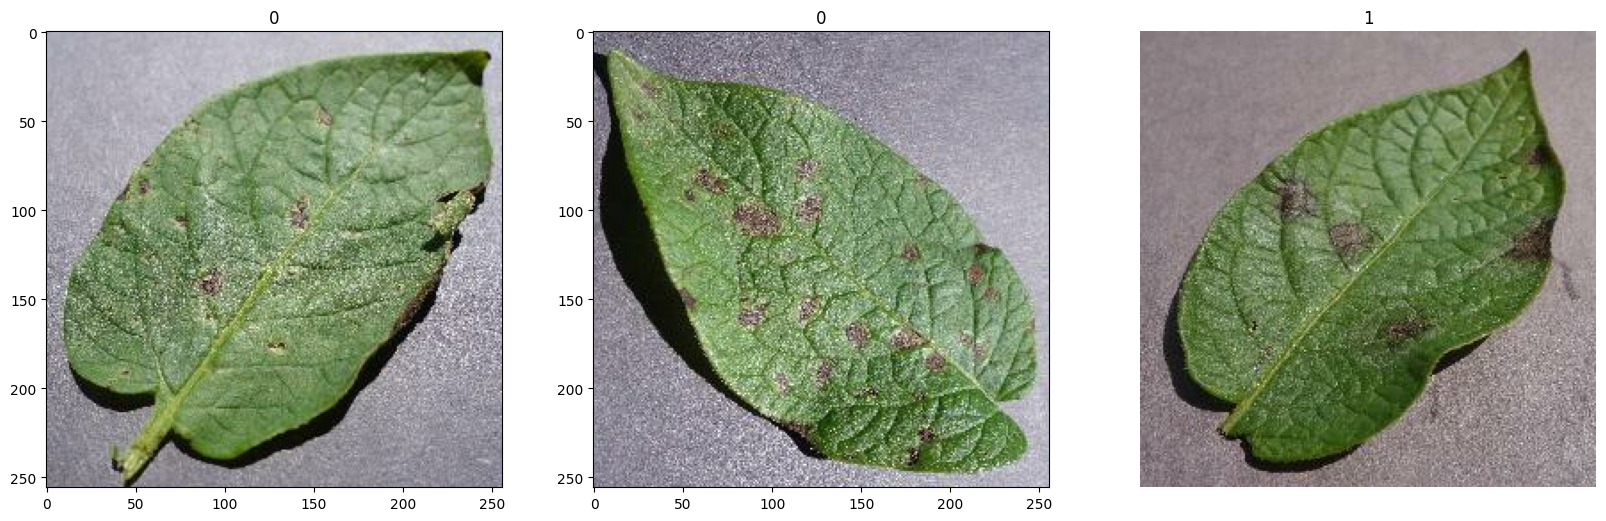

In [75]:
fig,ax = plt.subplots(ncols=3,figsize=(20,20))
for image_batch , label_batch in dataset.take(1):   # taking only first batch of 32 images
    print(image_batch.shape)      # batch shape
    print(label_batch.numpy())    # tensor -> numpy
    ax[0].imshow(image_batch[0].numpy().astype(int))
    ax[0].title.set_text(label_batch[0].numpy())
    ax[1].imshow(image_batch[1].numpy().astype(int))
    ax[1].title.set_text(label_batch[1].numpy())
    ax[2].imshow(image_batch[3].numpy().astype(int))
    ax[2].title.set_text(label_batch[2].numpy())
    plt.axis("off")
    plt.plot()

### 0 - late  ,  1 - early  ,  2 - healthy

In [80]:
train_size = int(len(dataset)*0.7)
val_size = int(len(dataset)*0.2)
test_size = int(len(dataset)*0.1)

In [81]:
train = dataset.take(train_size)
validation = dataset.skip(train_size).take(val_size)
test = dataset.skip(train_size+val_size).take(test_size)

In [85]:
#  making function to split data  
def  train_val_test(data , train = 0.70 , val = 0.20 , test = 0.10):
    train = int(len(data)*train)
    val = int(len(data)*val)
    test = int(len(data)*test)

    train_set = data.take(train)
    val_set = data.skip(train).take(val)
    test_set = data.spik(train+val).take(test)
    return train_set , val_set ,test_set

In [93]:
train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) 
validation.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) 
test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) 
# if gpu is under training then next batch will load from disk

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [100]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(img_h,img_w),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

# data agumentation
flip_and_rotation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [107]:
model = models.Sequential([
    resize_and_rescale,
    flip_and_rotation,
    layers.Conv2D(32,(3,3),activation = 'relu',input_shape=(32,img_h,img_w,3)),    # batch_size , h , w, channels
    layers.MaxPooling2D(),
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128,(3,3),activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(256,(3,3),activation = 'relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(3,activation='softmax')    # 3 - classes , early , late , healthy
])

In [108]:
model.build(input_shape=(32,img_h,img_w,3))

In [109]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (256, 256, 3)             0         
                                                                 
 sequential_2 (Sequential)   (256, 256, 3)             0         
                                                                 
 conv2d_8 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [117]:
model.compile(
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer = 'adam',
    metrics=['accuracy']
)

In [139]:
hist = model.fit(
    train,
    epochs=30,
    batch_size = 32,
    verbose = 1,
    validation_data =validation
)

Epoch 1/30


47/47 [==============================] - 100s 2s/step - loss: 0.1003 - accuracy: 0.9661 - val_loss: 0.1370 - val_accuracy: 0.9471
Epoch 2/30
47/47 [==============================] - 119s 3s/step - loss: 0.0783 - accuracy: 0.9688 - val_loss: 0.1838 - val_accuracy: 0.9231
Epoch 3/30
47/47 [==============================] - 134s 3s/step - loss: 0.1039 - accuracy: 0.9628 - val_loss: 0.1612 - val_accuracy: 0.9399
Epoch 4/30
47/47 [==============================] - 333s 7s/step - loss: 0.0783 - accuracy: 0.9754 - val_loss: 0.1284 - val_accuracy: 0.9519
Epoch 5/30
47/47 [==============================] - 424s 9s/step - loss: 0.0669 - accuracy: 0.9747 - val_loss: 0.0986 - val_accuracy: 0.9567
Epoch 6/30
47/47 [==============================] - 441s 9s/step - loss: 0.1021 - accuracy: 0.9661 - val_loss: 0.0993 - val_accuracy: 0.9519
Epoch 7/30
47/47 [==============================] - 441s 9s/step - loss: 0.0908 - accuracy: 0.9634 - val_loss: 0.2588 - val_accuracy: 0.8918
Epoch 8/30
47/47 [======

In [141]:
model.evaluate(test)

6/6 [==============================] - 3s 460ms/step - loss: 0.1287 - accuracy: 0.9583


[0.12870344519615173, 0.9583333134651184]

In [142]:

def model_predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array,0)    # create batch

    predictions = model.predict(img_array)

    predict_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predict_class , confidence

1/1 [==============================] - 0s 27ms/step


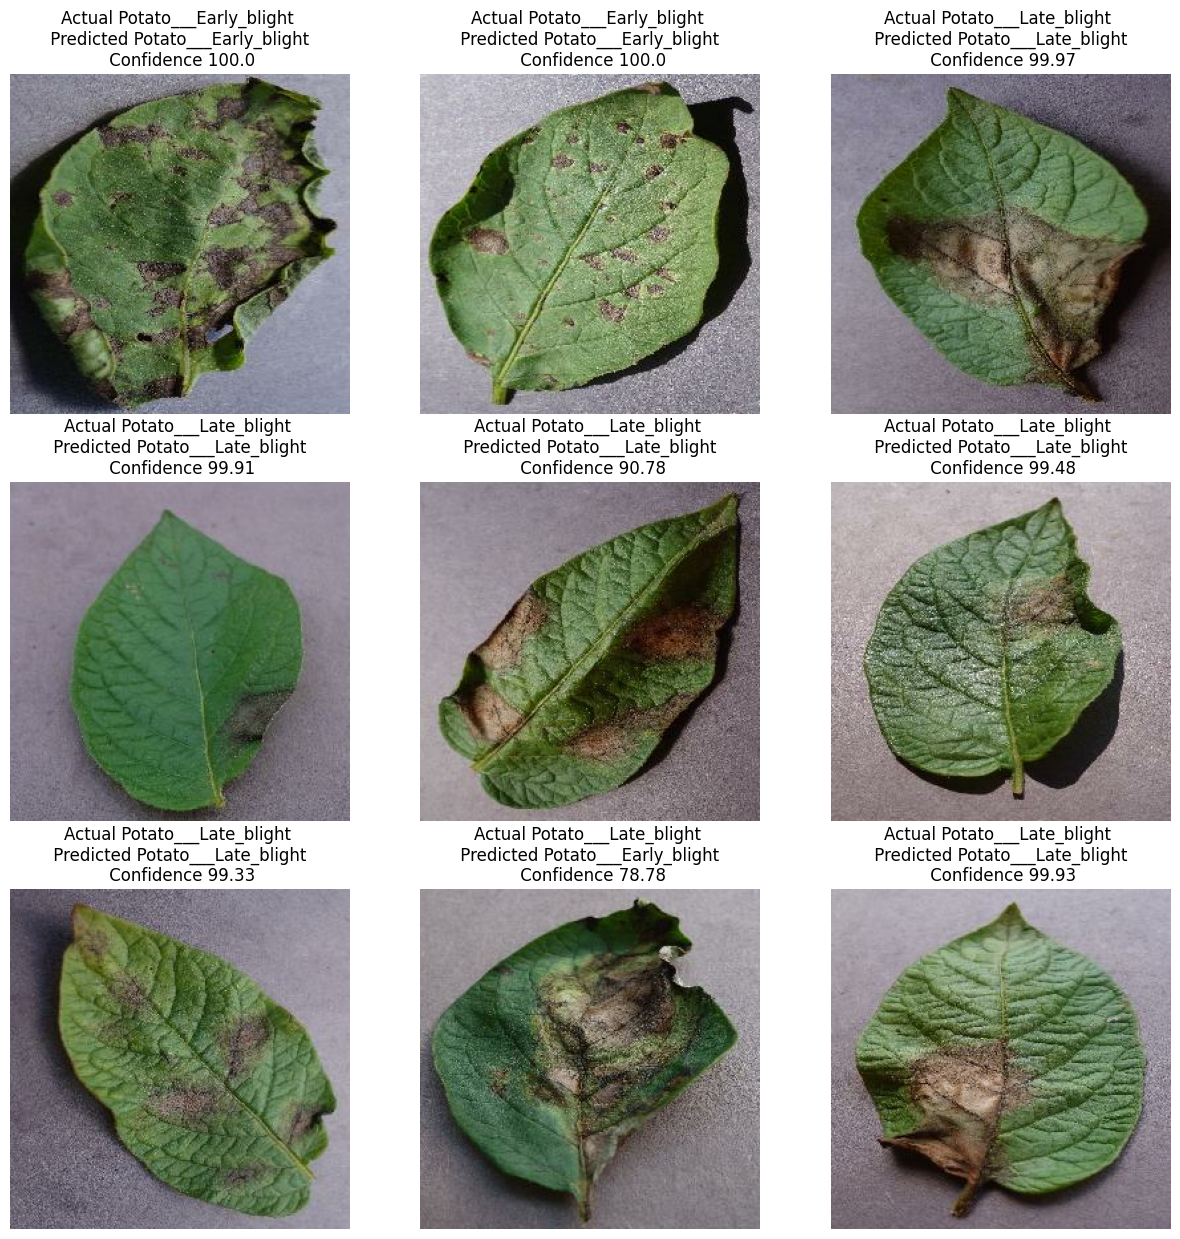

In [143]:
plt.figure(figsize=(15,15))
for img , labels in test.take(1):    # img -> batch of images  , labels -> array of labels
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(img[i].numpy().astype(int))
        predict_class , confidence = model_predict(model,img[i].numpy())
        plt.title(f"Actual {class_names[labels[i]]} \n Predicted {predict_class} \n Confidence {confidence}")
        plt.axis("off")


In [144]:
model_version = max([int(i) for i in os.listdir("models")]) +1
model.save(f"models/{model_version}")    # 87 accuracy 1st model   95-2nd

INFO:tensorflow:Assets written to: models/2\assets


INFO:tensorflow:Assets written to: models/2\assets
